In [1]:
"""
Purpose: Implementation fo DiffPool
graph coarsening manner

"""

'\nPurpose: Implementation fo DiffPool\ngraph coarsening manner\n\n'

In [2]:
%load_ext autoreload
%autoreload 2

In [146]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
#sys.path.append("/meshAfterParty/meshAfterParty")
sys.path.append("/python_tools/python_tools")
sys.path.append("/machine_learning_tools/machine_learning_tools/")
sys.path.append("/pytorch_tools/pytorch_tools/")
sys.path.append("/neuron_morphology_tools/neuron_morphology_tools/")
sys.path.append("/meshAfterParty/meshAfterParty/")

from importlib import reload

In [4]:
data_path = Path("../data/m65_full/")
list(data_path.iterdir())

[PosixPath('../data/m65_full/cell_type_fine_with_skeleton'),
 PosixPath('../data/m65_full/df_morphometrics.pbz2'),
 PosixPath('../data/m65_full/cell_type_fine_with_skeleton_no_dense'),
 PosixPath('../data/m65_full/cell_type_fine_with_skeleton_directed'),
 PosixPath('../data/m65_full/df_cell_type_fine.pbz2')]

In [5]:
#python_tools modules
import system_utils as su
import pandas_utils as pu
import pandas as pd
import numpy as np
import numpy_utils as nu
import networkx_utils as xu
from tqdm_utils import tqdm

#neuron_morphology_tools modules
import neuron_nx_io as nxio

In [6]:
import torch
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import Data
from torch_geometric import transforms

# for the dataset object
from torch_geometric.data import InMemoryDataset, download_url
from torch_geometric.loader import DataLoader
from torch_geometric.data import DenseDataLoader

In [7]:
#pytorch_tools modules
import preprocessing_utils as pret
import geometric_models as gm

# Step 0: Choosing the Model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

with_skeleton = True

features_to_delete = [
    "mesh_volume",
    "apical_label",
    "basal_label",
]

if not with_skeleton:
    features_to_delete +=[
        "skeleton_vector_downstream_phi",      
        "skeleton_vector_downstream_theta",    
        "skeleton_vector_upstream_phi",        
        "skeleton_vector_upstream_theta",  
    ]

features_to_keep = None


device = cpu


# Step 1: Loading the Graph Data

In [9]:
from pathlib import Path
import time
def load_data(
    gnn_task,
    data_file,#"df_cell_type_fine.pbz2"
    data_path = Path("./data/m65_full/"),
    data_df = None,
    label_name = None,
    graph_label = "cell_type_fine_label", 
    dense_adj = False,
    directed = False,
    features_to_remove = [
        "mesh_volume",
        "apical_label",
        "basal_label",
    ],
    with_skeleton=True,
    device = "cpu",
    
    #for the standardization
    df_standardization = None,
    
    cell_type_map = None,
    
    processed_data_folder_name = None,
    
    max_nodes = 300,
    
    #--------- processing the dataset ----
    clean_prior_dataset = False,
    data_source = None,
    verbose = True,
    
    return_cell_type_map = False,
    
    
    ):
    
    """
    Purpose: Will load the data for processing using the GNN models
    
    """
    if with_skeleton:
        gnn_task_name = f"{gnn_task}_with_skeleton"
        features_to_delete = features_to_remove
    else:
        gnn_task_name = f"{gnn_task}"
        
        features_to_delete = features_to_remove + [
        "skeleton_vector_downstream_phi",      
        "skeleton_vector_downstream_theta",    
        "skeleton_vector_upstream_phi",        
        "skeleton_vector_upstream_theta",  
        ]
            
    if processed_data_folder_name is None:
        if dense_adj:
            processed_data_folder = data_path / Path(f"{gnn_task_name}")#_processed_dense")
        elif directed:
            processed_data_folder = data_path / Path(f"{gnn_task_name}_directed")#_processed_dense")
        else:
            processed_data_folder = data_path / Path(f"{gnn_task_name}_no_dense")#_processed_dense")
    else:
        processed_data_folder = data_path / Path(f"{processed_data_folder_name}")

        
    #1) Load the data
    if verbose:
        print(f"Starting to load data")
        st = time.time()
        
    if data_df is None:
        data_filepath = Path(data_path) / Path(data_file)
        data_df = su.decompress_pickle(data_filepath)
    
    if verbose:
        print(f"Finished loading data: {time.time() - st}")
    
    #2) Getting the means and standard deviations if not already computed
    if df_standardization is None:
        if verbose:
            print(f"Started calculating normalization")
        all_batch_df = pd.concat([nxio.feature_df_from_gnn_info(
            k[0],
            return_data_labels_split = False) for k in data_df[gnn_task].to_list()])

        if label_name is not None:
            all_batch_df = all_batch_df[[k for k in 
                    all_batch_df.columns if k not in nu.convert_to_array_like(label_name)]]
        else:
            all_batch_df = all_batch_df

        # will use these to normalize the data
        col_means = all_batch_df.mean(axis=0).to_numpy()
        col_stds = all_batch_df.std(axis=0).to_numpy()
        df_standardization = pd.DataFrame(np.array([col_means,col_stds]),
             index=["norm_mean","norm_std"],
            columns=all_batch_df.columns)
        
        if verbose:
            print(f"Finished calculating normalization: {time.time() - st}")
        
        #max_nodes = np.max(all_batch_df.index.to_numpy()) + 1
        
#         all_batch_df_norm = pu.normalize_df(all_batch_df,
#                 column_means=df_standardization[all_batch_df.columns].loc["norm_mean",:],
#                 column_stds =df_standardization[all_batch_df.columns].loc["norm_std",:])
    try:
        col_means = df_standardization.loc["norm_mean",:].to_numpy()
    except:
        col_means = df_standardization.iloc[0,:].to_numpy()
    
    try:
        col_stds = df_standardization.loc["norm_std",:].to_numpy()
    except:
        col_stds = df_standardization.iloc[1,:].to_numpy()

    
    #3) Creating the Dataclass
    if cell_type_map is None:
        total_labels,label_counts = np.unique((data_df.query(f"{graph_label}=={graph_label}")[
        graph_label]).to_numpy(),return_counts = True)
        cell_type_map = {k:i+1 for i,k in enumerate(total_labels)}
        cell_type_map[None] = 0
    
    
    # ---------- Creating the dataset --------------------
    
    # --------- Functions for loading custom dataset -----
    def pytorch_data_from_gnn_info(
        gnn_info,
        y = None,
        verbose = False,
        normalize = True,
        features_to_delete=None,
        features_to_keep = None,
        data_name = None,
        data_source = None,
        ): 
        """
        Purpose: To convert our data format into pytorch Data object

        Pseudocode: 
        1) Create the edgelist (turn into tensor)
        2) Get the 
        """
        edgelist = torch.tensor(xu.edgelist_from_adjacency_matrix(
            array = gnn_info["adjacency"],
            verbose = False,
        ).T,dtype=torch.long)

        x,y_raw = nxio.feature_df_from_gnn_info(
            gnn_info,
            return_data_labels_split = True)
        if y is None:
            y = y_raw

        if not type(y) == str:
            y = None

        y_int = np.array(cell_type_map[y] ).reshape(1,-1)

        if normalize:
            x = (x-col_means)/col_stds

        # --- keeping or not keeping sertain features
        gnn_features = gnn_info["features"]

        keep_idx = np.arange(len(gnn_features))
        if features_to_delete is not None:
            curr_idx = np.array([i for i,k in enumerate(gnn_features)
                           if k not in features_to_delete])
            keep_idx = np.intersect1d(keep_idx,curr_idx)
            if verbose:
                print(f"keep_idx AFTER DELETE= {keep_idx}")
        if features_to_keep is not None:
            curr_idx = np.array([i for i,k in enumerate(gnn_features)
                           if k in features_to_keep])
            keep_idx = np.intersect1d(keep_idx,curr_idx)
            if verbose:
                print(f"keep_idx AFTER KEEP = {keep_idx}")

        x = x[:,keep_idx]

        x = torch.tensor(x,dtype=torch.float)
        y = torch.tensor(y_int,dtype=torch.long)

        if len(y) > 1:
            raise Exception(f"y = {y}")

        if y.shape[0] != 1 or y.shape[1] != 1:
            raise Exception(f"y = {y}")


        if verbose:
            print(f"x.shape = {x.shape},y.shape ={y.shape}")
        
        data_dict = dict(x=x,y=y,edge_index=edgelist)
        if data_name is not None:
            data_dict["data_name"] = data_name
            
        if data_source is not None:
            data_dict["data_source"] = data_source
            
        
        data = Data(**data_dict)
        
        return data

    class CellTypeDataset(InMemoryDataset):
        def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
            super().__init__(root, transform, pre_transform, pre_filter)
            self.data, self.slices = torch.load(self.processed_paths[0])

        @property
        def raw_file_names(self):
            #return ['some_file_1', 'some_file_2', ...]
            return [str(data_filepath.absolute())]

        @property
        def processed_file_names(self):
            return ['data.pt']

        # def download(self):
        #     # Download to `self.raw_dir`.
        #     download_url(url, self.raw_dir)
        #     ...

        def process(self):
            # Read data into huge `Data` list.
            #data_list = [...]

    #         if data_df is None:
    #             data_df = su.decompress_pickle(self.raw_file_names[0])


            data_list = []
            for k,y,segment_id,split_index in tqdm(zip(
                data_df[gnn_task].to_list(),
                data_df[graph_label].to_list(),
                data_df["segment_id"],
                data_df["split_index"])):
                
                if len(k) > 0:
                    data_list.append(pytorch_data_from_gnn_info(
                        k[0],
                        y=y,
                        features_to_delete=features_to_delete,
                        features_to_keep = features_to_keep,
                        data_name = f"{segment_id}_{split_index}",
                        data_source = data_source,
                        verbose = False))

            if self.pre_filter is not None:
                data_list_final = []
                for data in data_list:
                    try:
                        if self.pre_filter(data):
                            data_list_final.append(data)
                    except:
                        continue

                data_list = data_list_final

            for j,d in enumerate(data_list):
                if d.y.shape[0] != 1 or d.y.shape[1] != 1:
                    raise Exception(f"{j}")

            if self.pre_transform is not None:
                data_list_final = []
                for j,data in enumerate(data_list):
                    try:
                        curr_t = self.pre_transform(data)
                        if curr_t.y.shape[0] != 1 or curr_t.y.shape[1] != 1:
                            raise Exception(f"{j}, data = {curr_t}")
                        data_list_final.append(curr_t)
                    except:
                        continue
                data_list = data_list_final

            for j,d in enumerate(data_list):
                if d.y.shape[0] != 1 or d.y.shape[1] != 1:
                    raise Exception(f"{j}, data = {d}")

            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[0])
            
    # --- creating the folder for the dataset --
    if clean_prior_dataset:
        try:
            su.rm_dir(processed_data_folder)
        except:
            pass
        
    processed_data_folder.mkdir(exist_ok = True)
    
    
    # a) Processing Filteres
    class MyFilter(object):
        def __call__(self, data):
            return data.num_nodes <= max_nodes

    if dense_adj:
        #gets the maximum number of nodes in any of the graphs
        transform_list = [
            transforms.ToUndirected(),
            T.ToDense(max_nodes),
            #transforms.NormalizeFeatures(),
            ]
        re_filter = MyFilter()
    elif directed:
        transform_list = []
        pre_filter = None
    else:
        transform_list = [
            transforms.ToUndirected(),]

        pre_filter = None


    transform_norm = transforms.Compose(transform_list)
    
    
    # b) Creating the Dataset
    dataset = CellTypeDataset(
            processed_data_folder.absolute(),
            pre_transform = transform_norm,
            pre_filter = pre_filter,
            )
    
    if return_cell_type_map:
        return dataset,cell_type_map
    else:
        return dataset

# --- Running the preprocessing --

In [10]:
df_standardization = pu.csv_to_df("../data/cell_type_normalization_df.csv")
cell_type_map = su.decompress_pickle("../data/cell_type_map")

In [11]:
gnn_task = "cell_type_fine"
label_name = None
graph_label = "cell_type_fine_label"
data_file = "df_cell_type_fine.pbz2"
dense_adj = False
directed = False

data_path = Path("../data/m65_full/")
data_source = "m65"
processed_data_folder_name = f"{gnn_task}_{data_source}"

m65_dataset = load_data(
    gnn_task = gnn_task,
    data_file = data_file,
    data_path = data_path,
    label_name = label_name,
    graph_label = graph_label, 
    dense_adj = False,
    directed = False,
    features_to_remove = [
        "mesh_volume",
        "apical_label",
        "basal_label",
    ],
    with_skeleton=True,
    device = "cpu",
    
    #for the standardization
    df_standardization = df_standardization,
    cell_type_map = cell_type_map,
    
    processed_data_folder_name = processed_data_folder_name,
    
    max_nodes = 300,
    clean_prior_dataset = True,  
    data_source = data_source,
    
    
    
)

Starting to load data
Finished loading data: 41.575379371643066


Processing...


0it [00:00, ?it/s]

Done!


In [14]:
m65_dataset[1000].x

tensor([[-8.0464e-01, -7.7605e-01, -4.7999e-01, -7.3672e-01, -3.1193e-01,
         -9.9729e-01, -7.4410e-01,  2.3052e+00,  2.2274e+00,  4.5753e-01,
         -1.2475e+00,  4.3977e-01, -1.1927e+00,  2.7677e+00],
        [-2.7757e-02, -5.5046e-01,  3.0467e-01,  8.9487e+00, -3.1193e-01,
          2.2655e+00, -3.2317e-01,  2.1429e+00,  1.5464e+00,  1.1518e+00,
          3.5630e-01,  8.7508e-01, -2.5260e-01,  5.8747e-01],
        [-2.7757e-02, -4.3767e-01, -4.7999e-01,  7.5650e+00,  2.5289e+00,
          3.5847e+00, -4.3633e-01,  7.1761e-01, -1.0707e+00, -1.7654e-01,
          1.1751e-01, -7.2176e-02, -1.0149e+00, -5.4607e-01],
        [-6.6601e-02, -5.5046e-01,  1.8740e+00,  7.5840e+00, -3.1193e-01,
          3.3987e+00, -3.9865e-01, -1.2484e+00, -8.5420e-02,  1.0608e+00,
          1.3579e+00,  5.7661e-01,  5.4809e-01, -5.0159e-01],
        [-4.5504e-01, -7.1965e-01,  3.0467e-01,  5.1390e+00, -3.1193e-01,
          1.3663e+00, -6.3067e-01,  5.9305e-01, -2.5170e-01, -3.5350e-03,
         -1.

# -- a) creating the h01 dataset

In [15]:
cell_type_map.update({"Unsure E":32,"Unsure I":33})
cell_type_map

{'1P': 1,
 '23P': 2,
 '4P': 3,
 '5P_IT': 4,
 '5P_NP': 5,
 '5P_PT': 6,
 '6CT': 7,
 '6P': 8,
 '6P_CT': 9,
 '6P_IT': 10,
 '6P_U': 11,
 'BC': 12,
 'BPC': 13,
 'I targeting non_bpc': 14,
 'IT_big_tuft': 15,
 'IT_short': 16,
 'IT_small_tuft': 17,
 'Martinotti': 18,
 'NGC': 19,
 'Pvalb': 20,
 'SST': 21,
 'Unsure': 22,
 'VIP': 23,
 'WM_P': 24,
 'cb1 basket': 25,
 'chandelier': 26,
 'l1vip': 27,
 'ndnf+npy_': 28,
 'ngfc': 29,
 'prox targeting': 30,
 'small basket': 31,
 None: 0,
 'Unsure E': 32,
 'Unsure I': 33}

In [16]:
data_path= Path("../data/h01_full")
gnn_task = "cell_type_fine"
label_name = None
graph_label = "cell_type_fine_label"
data_file = "df_cell_type_fine_h01.pbz2"
dense_adj = False
directed = False
data_source = "h01"


processed_data_folder_name = f"{gnn_task}_h01"

df_standardization = pu.csv_to_df("../cell_type_normalization_df.csv")


h01_dataset = load_data(
    gnn_task = gnn_task,
    data_file = data_file,
    data_path = data_path,
    graph_label = graph_label, 
    dense_adj = False,
    directed = False,
    
    #for the standardization
    df_standardization = df_standardization,
    cell_type_map=cell_type_map,
    
    processed_data_folder_name = processed_data_folder_name,
    clean_prior_dataset = True,
    
    data_source = data_source,
)

Starting to load data
Finished loading data: 4.364929437637329


Processing...


0it [00:00, ?it/s]

Done!


In [17]:
dataset_num_node_features = m65_dataset.num_node_features
dataset_num_classes = m65_dataset.num_classes

# Loading the Model

In [162]:
%load_ext tensorboard
%tensorboard --logdir /pytorch_tools/Applications/Cell_Types_GNN/tensorboard/GCNFlat --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 470), started 1:23:41 ago. (Use '!kill 470' to kill it.)

In [18]:
import geometric_models as gm

In [177]:
import general_utils as gu
architecture_kwargs_global = dict(
    n_hidden_channels = 32, 
    global_pool_type="mean",
    n_layers = 2
)

architecture_kwargs_curr = dict(
    n_hidden_channels = 64,
    global_pool_type = "mean",
    n_layers = 2)

architecture_kwargs = gu.merge_dicts([architecture_kwargs_global,architecture_kwargs_curr])
architecture_kwargs

{'n_hidden_channels': 64, 'global_pool_type': 'mean', 'n_layers': 2}

In [178]:
model_name = "GCNFlat"
checkpoint_dir = Path("../model_checkpoints")
checkpoint_dir = checkpoint_dir / Path(f"{model_name}")

winning_name = (f"{model_name}_" + "_".join([f"{k}_{v}" for k,v in architecture_kwargs.items()]) +
                "_lr_0.01_with_skeleton_True")


epoch = 95
winning_dir = checkpoint_dir / Path(f"{winning_name}_checkpoints") 
winning_filepath = winning_dir / Path(f"{winning_name}_epoch_{epoch}")
winning_filepath.exists()

True

In [179]:
model = getattr(gm,model_name)(
    dataset_num_node_features=dataset_num_node_features,
    dataset_num_classes=dataset_num_classes,
    **architecture_kwargs,
    #use_bn=False
    )

checkpoint = torch.load(winning_filepath)
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.eval()

GCNFlat(
  (conv0): GCNConv(14, 64)
  (conv1): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=32, bias=True)
)

In [180]:
[list(model.parameters())]

[[Parameter containing:
  tensor([-0.0388, -0.0945, -0.1031, -0.0399,  0.1572, -0.0957, -0.0281,  0.0412,
           0.0323, -0.0073,  0.0709, -0.0440, -0.2030, -0.1492, -0.1935, -0.0963,
           0.1233, -0.0031,  0.1634,  0.0730, -0.1900, -0.0658, -0.1367, -0.0584,
          -0.0311, -0.0325, -0.1329, -0.0652, -0.1243,  0.0683, -0.0889, -0.0783,
           0.0130,  0.0259,  0.0203,  0.0633,  0.1450, -0.1458, -0.0949,  0.1138,
          -0.0656, -0.2236,  0.2479,  0.0141, -0.0834, -0.1790, -0.0129,  0.0540,
           0.1005, -0.0087, -0.1271,  0.0153, -0.0734, -0.0509, -0.0774,  0.0498,
          -0.0835, -0.1133, -0.1265, -0.0915, -0.0858,  0.0464,  0.0929,  0.0334],
         requires_grad=True),
  Parameter containing:
  tensor([[-5.6219e-02, -1.1191e-01,  1.1481e-01, -3.4607e-01,  1.1554e-01,
           -1.0570e-01, -1.6452e-01,  2.4649e-01, -1.8418e-02, -4.2956e-01,
            1.7623e-01, -3.4413e-01,  1.5501e-01, -7.3178e-02],
          [ 3.8766e-01, -5.5585e-02, -1.6711e-01,

# Running the Embeddings

In [181]:
dataset = m65_dataset + h01_dataset
print(f"m65_dataset = {len(m65_dataset)}")
print(f"h01_dataset = {len(h01_dataset)}")
print(f"dataset = {len(dataset)}")
# mask_m65 = np.zeros(len(dataset))
# mask_m65[:len(m65_dataset)] = 1

# mask_h01 = np.zeros(len(dataset))
# mask_h01[len(m65_dataset)] = 1

m65_dataset = 58948
h01_dataset = 9551
dataset = 68499


In [182]:
batch_size = 64

all_data_loader = DataLoader(
    dataset, 
    batch_size=batch_size,
    shuffle = False)

all_data_loader

In [183]:
device = "cpu"
model.eval()
embeddings = []
labels = []
data_names = []
data_sources = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    data = data.to(device)
    if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(data)

    out_array = out.detach().cpu().numpy()
    out_labels = data.y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    data_names.append(data.data_name)
    data_sources.append(data.data_source)
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)
data_names = np.hstack(data_names)
data_sources = np.hstack(data_sources)

  0%|          | 0/1071 [00:00<?, ?it/s]

In [244]:
embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels
embedding_df["cell_type_predicted"] = np.argmax(embeddings,axis=1)
embedding_df["data_name"] = data_names
embedding_df["data_source"] = data_sources

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(
    embedding_df,
    decoder_map,
    column_name = "cell_type"
)

def e_i_label(row):
    ct = row["cell_type"]
    if ct is None:
        return ct
    
    return ctu.e_i_label_from_cell_type_fine(ct)

embedding_df["e_i"] = pu.new_column_from_row_function(
    embedding_df,
    e_i_label,
)

embedding_df["cell_type_predicted"] = pu.new_column_from_dict_mapping(
    embedding_df,
    decoder_map,
    column_name = "cell_type_predicted"
)


def e_i_label_predicted(row):
    ct = row["cell_type_predicted"]
    if ct is None:
        return ct
    
    return ctu.e_i_label_from_cell_type_fine(ct)

embedding_df["e_i_predicted"] = pu.new_column_from_row_function(
    embedding_df,
    e_i_label_predicted,
)


In [245]:
embedding_df

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,cell_type,cell_type_predicted,data_name,data_source,e_i,e_i_predicted
0,9.237636e-04,6.919019e-02,3.806149e-01,8.432155e-02,3.691756e-02,1.139275e-02,0.001215,3.074362e-02,3.315582e-02,7.073063e-03,...,3.433730e-03,3.367269e-02,3.256357e-04,4.812210e-04,Unknown,23P,864691134339067925_0,m65,other,excitatory
1,9.281131e-08,7.144682e-04,1.208437e-02,9.383637e-05,1.356477e-03,5.056208e-08,0.964490,5.931716e-04,1.093273e-02,9.327042e-03,...,5.041455e-08,1.128229e-06,7.026829e-08,1.706022e-08,Unknown,5P_PT,864691134378215335_0,m65,other,excitatory
2,1.650995e-21,1.205618e-16,2.283169e-17,1.520596e-21,5.318140e-15,9.653396e-25,1.000000,3.021146e-16,1.262434e-12,2.525029e-11,...,4.425863e-22,1.036636e-22,1.798110e-20,2.263927e-22,Unknown,5P_PT,864691134550853780_0,m65,other,excitatory
3,1.288054e-04,3.273404e-02,2.022505e-01,1.610292e-02,7.079581e-02,8.371112e-04,0.127195,6.800871e-02,3.092187e-01,1.017639e-01,...,1.570242e-04,1.313688e-03,7.121161e-05,4.106671e-05,Unknown,6P,864691134628099318_0,m65,other,excitatory
4,6.050082e-05,1.204002e-02,6.347790e-01,1.178808e-01,3.384987e-03,4.720055e-04,0.000005,3.107762e-04,2.021662e-04,3.421111e-05,...,4.372035e-04,8.069254e-03,1.492352e-05,2.343467e-05,Unknown,23P,864691134668951908_0,m65,other,excitatory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68494,3.427178e-09,4.170166e-05,4.804707e-04,1.994262e-06,7.570462e-05,6.327803e-10,0.997216,2.999244e-05,9.164887e-04,1.208283e-03,...,1.737820e-09,2.564280e-08,3.404824e-09,6.336608e-10,Unsure I,5P_PT,100193771014_0,h01,inhibitory,excitatory
68495,4.190862e-05,3.727515e-02,5.777299e-01,2.858652e-02,2.826176e-02,5.101531e-05,0.074861,3.437288e-02,1.301068e-01,7.071046e-02,...,2.739164e-05,7.974554e-04,1.991397e-05,1.132484e-05,Unsure I,23P,100674114237_0,h01,inhibitory,excitatory
68496,1.534389e-28,9.872749e-25,3.456679e-27,7.478463e-31,1.118625e-19,4.450459e-31,1.000000,5.000755e-22,8.477081e-17,6.954973e-15,...,7.975772e-30,8.435726e-32,8.383681e-27,2.408422e-29,Unsure E,5P_PT,102290008027_0,h01,excitatory,excitatory
68497,2.308568e-05,3.157449e-05,2.538610e-06,1.032728e-06,1.387841e-03,2.776204e-04,0.945713,3.530745e-04,3.517592e-03,2.308950e-03,...,4.258332e-05,5.009091e-06,4.588343e-05,1.380743e-05,Unsure E,5P_PT,103526886623_0,h01,excitatory,excitatory


# Step 5: Doing the Predictions

In [246]:
import string_utils as stru
embed_cols = [k for k in embedding_df.columns if "int" in str(type(k))]#stru.is_int(k)]
np.array(embed_cols)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

# Step 6: Plotting the Embeddings

In [247]:
"""
Get the mask of m65 vs h01
extract the data the data names
Collect the X value and the y values

-> there might be certain masks want to apply
"""

'\nGet the mask of m65 vs h01\nextract the data the data names\nCollect the X value and the y values\n\n-> there might be certain masks want to apply\n'

In [248]:
import datajoint_utils as du
import cell_type_utils as ctu

In [249]:
%matplotlib inline
import visualizations_ml as vml
n_components = 3
import dimensionality_reduction_ml as dru
import pandas_ml as pdml


In [250]:
embedding_df_known = embedding_df.query("(cell_type != 'Unknown') and (cell_type != 'Unsure')").reset_index(drop=True)
embedding_df_known

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,cell_type,cell_type_predicted,data_name,data_source,e_i,e_i_predicted
0,1.344617e-06,5.465589e-04,3.387675e-01,6.506337e-01,6.786816e-03,3.474453e-05,1.135889e-07,1.159831e-04,3.742571e-04,7.337125e-05,...,1.466572e-06,5.203148e-05,1.940351e-07,3.861415e-07,4P,4P,864691134884748026_0,m65,excitatory,excitatory
1,8.173984e-06,3.651239e-03,6.663646e-01,3.092534e-01,1.270410e-02,6.041682e-05,1.103090e-05,3.604181e-04,1.039925e-03,2.341251e-04,...,1.044703e-05,2.214914e-04,1.547113e-06,2.125893e-06,23P,23P,864691134884761338_0,m65,excitatory,excitatory
2,3.629048e-04,2.011467e-02,2.321885e-01,1.779853e-01,1.346542e-01,3.100271e-03,2.993843e-03,5.542706e-02,1.634943e-01,6.168654e-02,...,4.727860e-04,2.711484e-03,1.511694e-04,1.734184e-04,5P_IT,23P,864691134884769786_0,m65,excitatory,excitatory
3,3.711112e-05,2.615280e-05,2.582554e-05,4.555680e-04,7.951885e-02,5.493062e-03,5.885907e-03,6.107274e-03,1.214142e-01,7.041033e-02,...,2.745096e-05,5.394384e-06,3.279280e-05,2.940253e-05,IT_short,6P_IT,864691134884879610_0,m65,excitatory,excitatory
4,7.955477e-04,4.972181e-02,5.932932e-01,1.813516e-01,4.230065e-02,9.639052e-04,5.056085e-03,1.203199e-02,2.334349e-02,1.193793e-02,...,1.131989e-03,6.693541e-03,3.814179e-04,3.458024e-04,23P,23P,864691134884945146_0,m65,excitatory,excitatory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12864,3.427178e-09,4.170166e-05,4.804707e-04,1.994262e-06,7.570462e-05,6.327803e-10,9.972162e-01,2.999244e-05,9.164887e-04,1.208283e-03,...,1.737820e-09,2.564280e-08,3.404824e-09,6.336608e-10,Unsure I,5P_PT,100193771014_0,h01,inhibitory,excitatory
12865,4.190862e-05,3.727515e-02,5.777299e-01,2.858652e-02,2.826176e-02,5.101531e-05,7.486105e-02,3.437288e-02,1.301068e-01,7.071046e-02,...,2.739164e-05,7.974554e-04,1.991397e-05,1.132484e-05,Unsure I,23P,100674114237_0,h01,inhibitory,excitatory
12866,1.534389e-28,9.872749e-25,3.456679e-27,7.478463e-31,1.118625e-19,4.450459e-31,1.000000e+00,5.000755e-22,8.477081e-17,6.954973e-15,...,7.975772e-30,8.435726e-32,8.383681e-27,2.408422e-29,Unsure E,5P_PT,102290008027_0,h01,excitatory,excitatory
12867,2.308568e-05,3.157449e-05,2.538610e-06,1.032728e-06,1.387841e-03,2.776204e-04,9.457125e-01,3.530745e-04,3.517592e-03,2.308950e-03,...,4.258332e-05,5.009091e-06,4.588343e-05,1.380743e-05,Unsure E,5P_PT,103526886623_0,h01,excitatory,excitatory


# a) UMAP on embedding (0.5 min dist)

In [251]:
method = "UMAP"
kwargs = dict(n_components =2,min_dist = 0.5,)

In [252]:
#mask_before_trans = np.ones(len(X_trans)).astype("bool")
data_source = "h01"

if data_source is not None:
    df_input = embedding_df_known.query(f"data_source == '{data_source}'").reset_index(drop=True)#.#.query("")
else:
    df_input = embedding_df_known

In [253]:
X_trans = dru.dimensionality_reduction_by_method(
        method=method,
        X = df_input[embed_cols].to_numpy().astype("float"),
        **kwargs
        )

In [254]:
trans_cols = [f"{method}_{k}" for k in range(X_trans.shape[1])]
df_input = pd.concat([df_input,pd.DataFrame(X_trans,columns = trans_cols)],axis = 1)
df_input

,0,1,2,3,4,5,6,7,8,9,...,30,31,cell_type,cell_type_predicted,data_name,data_source,e_i,e_i_predicted,UMAP_0,UMAP_1
0,3.607896e-05,1.667201e-03,5.748343e-03,1.369706e-03,7.107513e-02,5.013495e-04,0.746560,6.302519e-03,6.976736e-02,4.171733e-02,...,2.916501e-05,1.117864e-05,Unsure E,5P_PT,329164988_0,h01,excitatory,excitatory,8.531158,12.196391
1,5.320992e-05,6.602645e-03,6.019367e-02,1.446254e-02,2.385547e-01,1.368901e-03,0.309371,2.158731e-02,1.770992e-01,8.449542e-02,...,3.123054e-05,1.731768e-05,Unsure E,5P_PT,329165083_0,h01,excitatory,excitatory,13.268115,6.818304
2,3.321955e-09,6.890896e-07,5.539362e-07,1.931065e-08,1.973795e-05,1.107382e-09,0.999285,4.215658e-06,2.434899e-04,3.867163e-04,...,5.537260e-09,1.052733e-09,Unsure E,5P_PT,329209038_0,h01,excitatory,excitatory,-2.025044,9.802788
3,5.539144e-08,1.770815e-06,8.904814e-07,1.396355e-07,1.659988e-04,6.589499e-08,0.996108,2.675950e-05,1.176024e-03,1.866275e-03,...,9.950901e-08,2.350760e-08,Unsure E,5P_PT,329384517_0,h01,excitatory,excitatory,-0.418084,17.882299
4,3.599071e-07,1.988988e-05,3.145151e-05,1.268545e-05,2.146679e-03,2.206824e-07,0.986617,3.878057e-05,1.856487e-03,2.707717e-03,...,4.335359e-07,1.511181e-07,Unsure E,5P_PT,329458855_0,h01,excitatory,excitatory,6.321417,19.674223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9546,3.427178e-09,4.170166e-05,4.804707e-04,1.994262e-06,7.570462e-05,6.327803e-10,0.997216,2.999244e-05,9.164887e-04,1.208283e-03,...,3.404824e-09,6.336608e-10,Unsure I,5P_PT,100193771014_0,h01,inhibitory,excitatory,-1.844392,16.062899
9547,4.190862e-05,3.727515e-02,5.777299e-01,2.858652e-02,2.826176e-02,5.101531e-05,0.074861,3.437288e-02,1.301068e-01,7.071046e-02,...,1.991397e-05,1.132484e-05,Unsure I,23P,100674114237_0,h01,inhibitory,excitatory,18.270279,-1.379619
9548,1.534389e-28,9.872749e-25,3.456679e-27,7.478463e-31,1.118625e-19,4.450459e-31,1.000000,5.000755e-22,8.477081e-17,6.954973e-15,...,8.383681e-27,2.408422e-29,Unsure E,5P_PT,102290008027_0,h01,excitatory,excitatory,-6.551939,8.032255
9549,2.308568e-05,3.157449e-05,2.538610e-06,1.032728e-06,1.387841e-03,2.776204e-04,0.945713,3.530745e-04,3.517592e-03,2.308950e-03,...,4.588343e-05,1.380743e-05,Unsure E,5P_PT,103526886623_0,h01,excitatory,excitatory,11.768537,17.918432


In [255]:
df_plot = df_input
df_plot

,0,1,2,3,4,5,6,7,8,9,...,30,31,cell_type,cell_type_predicted,data_name,data_source,e_i,e_i_predicted,UMAP_0,UMAP_1
0,3.607896e-05,1.667201e-03,5.748343e-03,1.369706e-03,7.107513e-02,5.013495e-04,0.746560,6.302519e-03,6.976736e-02,4.171733e-02,...,2.916501e-05,1.117864e-05,Unsure E,5P_PT,329164988_0,h01,excitatory,excitatory,8.531158,12.196391
1,5.320992e-05,6.602645e-03,6.019367e-02,1.446254e-02,2.385547e-01,1.368901e-03,0.309371,2.158731e-02,1.770992e-01,8.449542e-02,...,3.123054e-05,1.731768e-05,Unsure E,5P_PT,329165083_0,h01,excitatory,excitatory,13.268115,6.818304
2,3.321955e-09,6.890896e-07,5.539362e-07,1.931065e-08,1.973795e-05,1.107382e-09,0.999285,4.215658e-06,2.434899e-04,3.867163e-04,...,5.537260e-09,1.052733e-09,Unsure E,5P_PT,329209038_0,h01,excitatory,excitatory,-2.025044,9.802788
3,5.539144e-08,1.770815e-06,8.904814e-07,1.396355e-07,1.659988e-04,6.589499e-08,0.996108,2.675950e-05,1.176024e-03,1.866275e-03,...,9.950901e-08,2.350760e-08,Unsure E,5P_PT,329384517_0,h01,excitatory,excitatory,-0.418084,17.882299
4,3.599071e-07,1.988988e-05,3.145151e-05,1.268545e-05,2.146679e-03,2.206824e-07,0.986617,3.878057e-05,1.856487e-03,2.707717e-03,...,4.335359e-07,1.511181e-07,Unsure E,5P_PT,329458855_0,h01,excitatory,excitatory,6.321417,19.674223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9546,3.427178e-09,4.170166e-05,4.804707e-04,1.994262e-06,7.570462e-05,6.327803e-10,0.997216,2.999244e-05,9.164887e-04,1.208283e-03,...,3.404824e-09,6.336608e-10,Unsure I,5P_PT,100193771014_0,h01,inhibitory,excitatory,-1.844392,16.062899
9547,4.190862e-05,3.727515e-02,5.777299e-01,2.858652e-02,2.826176e-02,5.101531e-05,0.074861,3.437288e-02,1.301068e-01,7.071046e-02,...,1.991397e-05,1.132484e-05,Unsure I,23P,100674114237_0,h01,inhibitory,excitatory,18.270279,-1.379619
9548,1.534389e-28,9.872749e-25,3.456679e-27,7.478463e-31,1.118625e-19,4.450459e-31,1.000000,5.000755e-22,8.477081e-17,6.954973e-15,...,8.383681e-27,2.408422e-29,Unsure E,5P_PT,102290008027_0,h01,excitatory,excitatory,-6.551939,8.032255
9549,2.308568e-05,3.157449e-05,2.538610e-06,1.032728e-06,1.387841e-03,2.776204e-04,0.945713,3.530745e-04,3.517592e-03,2.308950e-03,...,4.588343e-05,1.380743e-05,Unsure E,5P_PT,103526886623_0,h01,excitatory,excitatory,11.768537,17.918432


<AxesSubplot:title={'center':'UMAP'}, xlabel='feature_0 ', ylabel='feature_1 '>

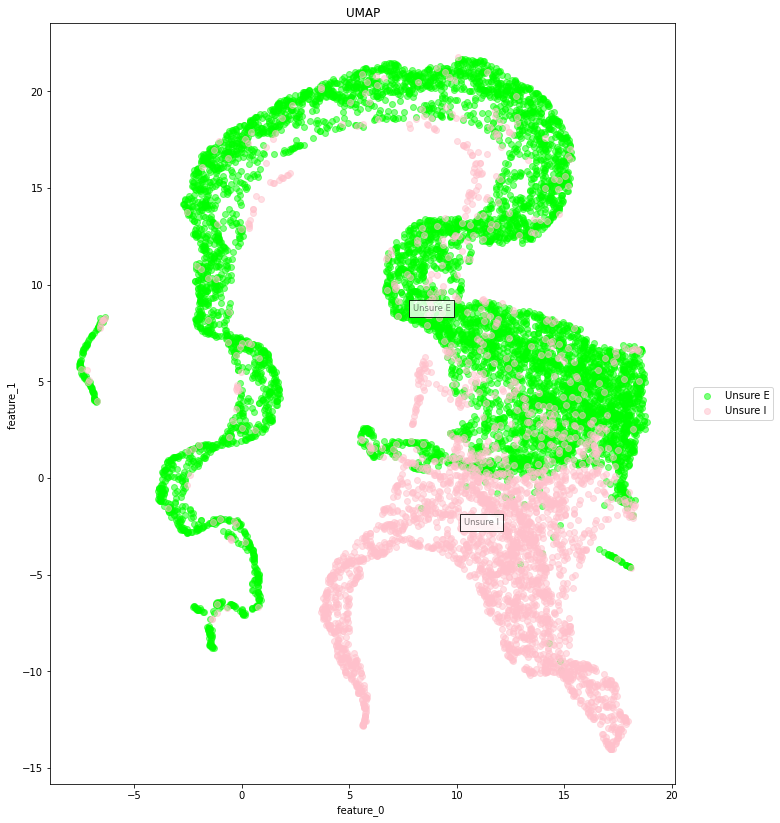

In [256]:
vml.plot_df_scatter_classification(
                X = df_plot[trans_cols].to_numpy().astype("float"),
                y = df_plot["cell_type"].to_numpy(),
                target_to_color = ctu.cell_type_fine_color_map,
                ndim = len(trans_cols),
                title=method,
                use_labels_as_text_to_plot=True,
            )

# Sampling the Space

In [265]:
from dataInterfaceH01 import data_interface as hdju_h01

In [257]:
data_source = "h01"
embedding_df_known.query("data_source == 'h01'").query("cell_type_predicted=='Martinotti'")

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,cell_type,cell_type_predicted,data_name,data_source,e_i,e_i_predicted
3325,0.000309,0.001567,0.003282,0.003185,0.001053,0.005546,7.209196e-06,0.000632,0.000230,7.363682e-05,...,0.005292,0.012972,0.000201,0.000331,Unsure I,Martinotti,330158986_0,h01,inhibitory,inhibitory
3352,0.002737,0.009716,0.008541,0.008681,0.012796,0.037913,6.270334e-04,0.018657,0.010552,4.537607e-03,...,0.017245,0.041024,0.001988,0.002709,Unsure I,Martinotti,389161997_0,h01,inhibitory,inhibitory
3355,0.001071,0.000398,0.000090,0.000235,0.003168,0.075689,2.353388e-04,0.004246,0.002738,1.035682e-03,...,0.015435,0.005060,0.001397,0.001641,Unsure I,Martinotti,401514872_0,h01,inhibitory,inhibitory
3371,0.000323,0.000281,0.000210,0.000442,0.001313,0.041843,1.245482e-05,0.000741,0.000349,1.009143e-04,...,0.006528,0.004766,0.000272,0.000426,Unsure I,Martinotti,445565866_0,h01,inhibitory,inhibitory
3373,0.000376,0.007925,0.048847,0.030850,0.009361,0.015506,2.215898e-05,0.003244,0.001746,3.416984e-04,...,0.003777,0.023748,0.000146,0.000269,Unsure I,Martinotti,447126518_0,h01,inhibitory,inhibitory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12852,0.000302,0.021113,0.286478,0.085520,0.022553,0.005830,7.795681e-05,0.002326,0.002139,2.499516e-04,...,0.002196,0.013463,0.000086,0.000131,Unsure I,Martinotti,89446706153_0,h01,inhibitory,inhibitory
12853,0.000015,0.000392,0.007516,0.003954,0.000304,0.001260,5.453514e-08,0.000014,0.000006,5.481690e-07,...,0.000373,0.001666,0.000004,0.000010,Unsure I,Martinotti,89696952585_0,h01,inhibitory,inhibitory
12854,0.001010,0.012682,0.042206,0.039331,0.091120,0.131380,6.162986e-04,0.038947,0.046181,8.651212e-03,...,0.006108,0.019231,0.000468,0.000638,Unsure I,Martinotti,89856118297_0,h01,inhibitory,inhibitory
12857,0.000467,0.020127,0.251986,0.116638,0.088382,0.048426,2.481219e-04,0.010058,0.013204,1.717595e-03,...,0.002116,0.013554,0.000137,0.000204,Unsure I,Martinotti,92286307998_0,h01,inhibitory,inhibitory


In [268]:
embedding_df_known.query("data_source == 'h01'")

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,cell_type,cell_type_predicted,data_name,data_source,e_i,e_i_predicted
3318,3.607896e-05,1.667201e-03,5.748343e-03,1.369706e-03,7.107513e-02,5.013495e-04,0.746560,6.302519e-03,6.976736e-02,4.171733e-02,...,3.098347e-05,5.896362e-05,2.916501e-05,1.117864e-05,Unsure E,5P_PT,329164988_0,h01,excitatory,excitatory
3319,5.320992e-05,6.602645e-03,6.019367e-02,1.446254e-02,2.385547e-01,1.368901e-03,0.309371,2.158731e-02,1.770992e-01,8.449542e-02,...,5.284974e-05,2.892917e-04,3.123054e-05,1.731768e-05,Unsure E,5P_PT,329165083_0,h01,excitatory,excitatory
3320,3.321955e-09,6.890896e-07,5.539362e-07,1.931065e-08,1.973795e-05,1.107382e-09,0.999285,4.215658e-06,2.434899e-04,3.867163e-04,...,1.966516e-09,1.166670e-09,5.537260e-09,1.052733e-09,Unsure E,5P_PT,329209038_0,h01,excitatory,excitatory
3321,5.539144e-08,1.770815e-06,8.904814e-07,1.396355e-07,1.659988e-04,6.589499e-08,0.996108,2.675950e-05,1.176024e-03,1.866275e-03,...,3.431640e-08,1.119571e-08,9.950901e-08,2.350760e-08,Unsure E,5P_PT,329384517_0,h01,excitatory,excitatory
3322,3.599071e-07,1.988988e-05,3.145151e-05,1.268545e-05,2.146679e-03,2.206824e-07,0.986617,3.878057e-05,1.856487e-03,2.707717e-03,...,1.761347e-07,8.793062e-08,4.335359e-07,1.511181e-07,Unsure E,5P_PT,329458855_0,h01,excitatory,excitatory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12864,3.427178e-09,4.170166e-05,4.804707e-04,1.994262e-06,7.570462e-05,6.327803e-10,0.997216,2.999244e-05,9.164887e-04,1.208283e-03,...,1.737820e-09,2.564280e-08,3.404824e-09,6.336608e-10,Unsure I,5P_PT,100193771014_0,h01,inhibitory,excitatory
12865,4.190862e-05,3.727515e-02,5.777299e-01,2.858652e-02,2.826176e-02,5.101531e-05,0.074861,3.437288e-02,1.301068e-01,7.071046e-02,...,2.739164e-05,7.974554e-04,1.991397e-05,1.132484e-05,Unsure I,23P,100674114237_0,h01,inhibitory,excitatory
12866,1.534389e-28,9.872749e-25,3.456679e-27,7.478463e-31,1.118625e-19,4.450459e-31,1.000000,5.000755e-22,8.477081e-17,6.954973e-15,...,7.975772e-30,8.435726e-32,8.383681e-27,2.408422e-29,Unsure E,5P_PT,102290008027_0,h01,excitatory,excitatory
12867,2.308568e-05,3.157449e-05,2.538610e-06,1.032728e-06,1.387841e-03,2.776204e-04,0.945713,3.530745e-04,3.517592e-03,2.308950e-03,...,4.258332e-05,5.009091e-06,4.588343e-05,1.380743e-05,Unsure E,5P_PT,103526886623_0,h01,excitatory,excitatory


In [270]:
# finding where disagrees
embedding_df_known.query("data_source == 'h01'").query("e_i != e_i_predicted").query("cell_type=='Unsure E'")

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,cell_type,cell_type_predicted,data_name,data_source,e_i,e_i_predicted
3775,0.000111,5.818680e-05,1.213554e-05,4.815022e-05,0.064510,0.037567,0.182819,0.008129,0.108138,0.050022,...,0.000113,1.639601e-05,0.000132,0.000070,Unsure E,Unsure,1698330095_0,h01,excitatory,other
3822,0.003585,4.321776e-03,1.918614e-03,2.391612e-03,0.046006,0.080446,0.033050,0.026811,0.045994,0.025713,...,0.016084,7.031108e-03,0.004649,0.003103,Unsure E,Unsure,1812744584_0,h01,excitatory,other
4282,0.000029,1.058289e-05,2.071164e-06,9.407819e-06,0.077713,0.112139,0.234344,0.004376,0.077841,0.030125,...,0.000043,5.451671e-06,0.000039,0.000019,Unsure E,Unsure,2642474626_0,h01,excitatory,other
4390,0.000033,2.095569e-05,4.041879e-06,1.649751e-05,0.096802,0.144667,0.135731,0.007141,0.121926,0.031680,...,0.000039,7.809716e-06,0.000033,0.000018,Unsure E,Unsure,2815862747_0,h01,excitatory,other
4401,0.001461,6.445208e-03,9.719471e-03,1.045082e-02,0.035140,0.185141,0.000345,0.014610,0.016658,0.002737,...,0.008457,1.189545e-02,0.000717,0.000998,Unsure E,Martinotti,2830214431_0,h01,excitatory,inhibitory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12105,0.000008,3.092730e-07,2.440733e-08,1.597371e-06,0.038136,0.148473,0.006538,0.002218,0.067192,0.024780,...,0.000007,2.840242e-07,0.000011,0.000008,Unsure E,Unsure,43240307073_0,h01,excitatory,other
12107,0.000048,3.351484e-05,8.856420e-06,3.515834e-05,0.078101,0.094529,0.046098,0.005611,0.085084,0.018837,...,0.000113,1.225971e-05,0.000043,0.000027,Unsure E,Unsure,43326920740_0,h01,excitatory,other
12217,0.000029,4.961381e-06,7.596575e-07,1.152278e-05,0.067306,0.248456,0.012544,0.004746,0.077674,0.020276,...,0.000041,4.048724e-06,0.000032,0.000020,Unsure E,Unsure,46836446896_0,h01,excitatory,other
12636,0.000002,4.069675e-08,7.127621e-10,1.206128e-07,0.018446,0.008136,0.097588,0.000526,0.039867,0.033191,...,0.000001,1.845559e-08,0.000007,0.000004,Unsure E,Unsure,66470118873_0,h01,excitatory,other


In [262]:
from importlib import reload
import trimesh_utils as tu
import human_utils as hu
tu = reload(tu)

# Visualizing Wrong ones

In [ ]:
"""
Excitatory's that are wrong are mostly the aspiny

"""

In [274]:
hdju_h01.plot_axon_dendrite_skeletons("46836446896_0")

axon_skeleton length = 0
dendrite_skeleton length = 593558.030175207


# Finding the 5 closest cells

In [308]:
data_source = "m65"
data_source_df = embedding_df_known.query(f"data_source == '{data_source}'").query("cell_type=='BC'")
data_source_df

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,cell_type,cell_type_predicted,data_name,data_source,e_i,e_i_predicted
158,0.006497,4.355035e-02,5.926044e-02,2.343513e-02,0.031372,0.006795,0.051631,0.030430,0.030369,0.028473,...,0.027088,0.041269,0.007947,0.005408,BC,Martinotti,864691135104181325_0,m65,inhibitory,inhibitory
161,0.000755,1.075105e-04,1.017713e-05,1.957139e-05,0.000982,0.002868,0.026709,0.001101,0.001345,0.002818,...,0.010529,0.000783,0.003441,0.001332,BC,BC,864691135104298829_0,m65,inhibitory,inhibitory
286,0.000079,3.732429e-07,9.683520e-09,2.269280e-07,0.000080,0.019249,0.000070,0.000046,0.000046,0.000063,...,0.003628,0.000043,0.000498,0.000241,BC,BC,864691135194776874_0,m65,inhibitory,inhibitory
302,0.000326,3.213014e-05,1.499077e-06,1.039027e-06,0.000012,0.000033,0.006953,0.000021,0.000011,0.000047,...,0.010194,0.000431,0.002320,0.000765,BC,BC,864691135210272448_0,m65,inhibitory,inhibitory
379,0.002320,8.033385e-04,2.215954e-04,3.798627e-04,0.001415,0.006930,0.001467,0.001381,0.000787,0.000915,...,0.035239,0.008279,0.005212,0.003597,BC,Martinotti,864691135272313361_0,m65,inhibitory,inhibitory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3060,0.002092,6.002599e-04,8.268208e-05,6.552372e-05,0.000338,0.000680,0.011369,0.000459,0.000266,0.000575,...,0.032395,0.004333,0.007287,0.003497,BC,BC,864691136443751043_0,m65,inhibitory,inhibitory
3115,0.000254,3.937063e-06,1.356897e-07,1.128972e-06,0.000118,0.009302,0.000222,0.000147,0.000104,0.000133,...,0.008694,0.000204,0.001214,0.000621,BC,BC,864691136577834260_0,m65,inhibitory,inhibitory
3260,0.000200,4.005401e-06,1.455868e-07,6.380351e-07,0.000053,0.003475,0.000408,0.000049,0.000033,0.000052,...,0.007718,0.000197,0.001024,0.000498,BC,BC,864691136925825354_0,m65,inhibitory,inhibitory
3276,0.000769,5.060855e-05,3.800350e-06,7.848103e-06,0.000089,0.001038,0.001067,0.000132,0.000066,0.000146,...,0.021330,0.001192,0.003694,0.001687,BC,BC,864691136965943758_0,m65,inhibitory,inhibitory


In [309]:
node_name = "864691134884769786_0" # IT cell

X = data_source_df[embed_cols]
data_point = data_source_df.query(f"data_name=='{node_name}'")[embed_cols].to_numpy()
data_point

array([[2.0042896e-04, 4.0054010e-06, 1.4558678e-07, 6.3803515e-07,
        5.2639491e-05, 3.4747433e-03, 4.0818172e-04, 4.8648297e-05,
        3.2542001e-05, 5.2401676e-05, 4.2412499e-05, 1.4346007e-04,
        7.6055324e-01, 1.0009962e-01, 4.7377329e-03, 8.2767823e-05,
        7.9220663e-05, 7.5464741e-05, 6.8639457e-02, 1.5048659e-04,
        5.2376296e-03, 7.6191872e-03, 2.9351735e-02, 7.8594349e-03,
        1.2790671e-04, 1.6842644e-04, 5.8679230e-04, 7.3280797e-04,
        7.7183316e-03, 1.9717505e-04, 1.0239487e-03, 4.9837830e-04]],
      dtype=float32)

In [ ]:
from dataInterfaceMinnie65 import data_interface as hdju_m65
import gnn_embedding_utils as gnneu

node_name = "864691136925825354_0"
node_name = "864691135272313361_0"

gnneu.closest_neighbors_in_embedding_df(
    df = data_source_df,
    data_name = node_name,
    n_neighbors = 5,
    verbose = True,
    plot = True,
    plotting_func = hdju_m65.plot_axon_dendrite_skeletons,
    
    )

embedding_columns determined as [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
node_df data = {'cell_type': 'BC', 'cell_type_predicted': 'BC'}
closest_neighbors_idx = [68 10 52 32 44 67]
Closest Neighbors: 
{'data_name': '864691135374059081_0', 'cell_type': 'BC', 'cell_type_predicted': 'BC'}
{'data_name': '864691135772037371_0', 'cell_type': 'BC', 'cell_type_predicted': 'BC'}
{'data_name': '864691135581848173_0', 'cell_type': 'BC', 'cell_type_predicted': 'BC'}
{'data_name': '864691135730563769_0', 'cell_type': 'BC', 'cell_type_predicted': 'BC'}
{'data_name': '864691136577834260_0', 'cell_type': 'BC', 'cell_type_predicted': 'BC'}


--- Plotting -----
Original data: 864691136925825354_0
